# Imports

## Environment Variables

In [1]:
import os
from dotenv import load_dotenv

# Load environment variables
load_dotenv()
ANTHROPIC_MODEL = os.getenv("ANTHROPIC_MODEL")
OPENAI_MODEL = os.getenv("OPENAI_MODEL")

# Verify keys are loaded
print(f'Anthropic API Key loaded: {bool(os.getenv("ANTHROPIC_API_KEY"))}\nAnthropic model: {os.getenv("ANTHROPIC_MODEL")}')
print(f'OpenAI API Key loaded: {bool(os.getenv("OPENAI_API_KEY"))}\nOpenAI model: {os.getenv("OPENAI_MODEL")}')
print(f'Langsmith API Key loaded: {bool(os.getenv("LANGSMITH_API_KEY"))}')

Anthropic API Key loaded: True
Anthropic model: claude-sonnet-4-20250514
OpenAI API Key loaded: True
OpenAI model: gpt-4o-mini
Langsmith API Key loaded: True


## Packages

In [2]:
from typing import Literal, TypedDict, Annotated
from datetime import datetime
import json
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, AnyMessage
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END, START
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode

# Configure LLM
&rarr; choose anthropic / openai 

In [3]:
def get_llm(provider: Literal["anthropic", "openai"] = "openai"):
    """Get LLM instance based on provider choice"""
    if provider == "anthropic":
        base_llm = ChatAnthropic(
            model=ANTHROPIC_MODEL,
            temperature=0.7,
            max_tokens=1024
        )
    elif provider == "openai":
        base_llm = ChatOpenAI(
            model=OPENAI_MODEL,
            temperature=0.7,
            max_tokens=1024
        )
    else:
        raise ValueError(f"Unknown provider: {provider}")
    
    return base_llm


# Choose your provider here
LLM_PROVIDER = "openai"  # Change to "anthropic" if you prefer
llm = get_llm(LLM_PROVIDER)

print(f"Using {LLM_PROVIDER.upper()} as LLM provider")

Using OPENAI as LLM provider


# Load system prompts

In [4]:
def load_system_prompt(filename: str) -> str:
    """Load the system prompt from your markdown file."""
    with open(f"prompts/{filename}.md", 'r', encoding='utf-8') as f:
        return f.read()

In [5]:
# Load different prompts for different parts of your workflow
CONTRACT_COLLECTION_PROMPT = load_system_prompt("contract_chatbot_system_prompt")
# VALIDATION_PROMPT = load_system_prompt("data_validation_prompt")
# EMAIL_GENERATION_PROMPT = load_system_prompt("email_generation_prompt")

# Tools

## Create tools

### get_current_datetime

In [25]:
# =============================================================================
# TOOLS: DATE HANDLING
# =============================================================================
# Tools for parsing and resolving relative date expressions.

import re
import calendar
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse as dateutil_parse

# Mapping of day names to weekday numbers (Monday=0, Sunday=6)
WEEKDAY_MAP = {
    "monday": 0, "mon": 0,
    "tuesday": 1, "tue": 1, "tues": 1,
    "wednesday": 2, "wed": 2,
    "thursday": 3, "thu": 3, "thur": 3, "thurs": 3,
    "friday": 4, "fri": 4,
    "saturday": 5, "sat": 5,
    "sunday": 6, "sun": 6,
}

WEEKDAY_NAMES = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]


def get_weekday_from_text(text: str) -> int | None:
    """Extract weekday number from text. Returns None if not found."""
    text = text.lower().strip()
    for day_name, day_num in WEEKDAY_MAP.items():
        if day_name in text:
            return day_num
    return None


@tool
def parse_relative_date(date_expression: str) -> str:
    """
    Parse a relative date expression and return the resolved date.
    
    Use this tool when the user mentions relative dates like:
    - "today", "tomorrow", "yesterday"
    - "next Monday", "this Friday", "last Tuesday"  
    - "in 3 days", "in 2 weeks", "in 1 month"
    - "3 weeks from now", "2 months from today"
    - "next week", "next month"
    - "end of month"
    
    Args:
        date_expression: Natural language date expression
    
    Returns:
        Formatted string: "DayOfWeek, YYYY-MM-DD" (e.g., "Friday, 2026-01-23")
    """
    today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
    current_weekday = today.weekday()  # Monday=0, Sunday=6
    expr = date_expression.lower().strip()
    result_date = None
    
    # --- SIMPLE RELATIVE DAYS ---
    if expr in ["today", "now"]:
        result_date = today
    
    elif expr == "tomorrow":
        result_date = today + relativedelta(days=1)
    
    elif expr == "yesterday":
        result_date = today - relativedelta(days=1)
    
    # --- "IN X DAYS/WEEKS/MONTHS/YEARS" or "X days/weeks from now" ---
    elif re.search(r'\d+\s*(day|week|month|year)', expr):
        match = re.search(r'(\d+)\s*(day|week|month|year)s?', expr)
        if match:
            num = int(match.group(1))
            unit = match.group(2)
            if unit == "day":
                result_date = today + relativedelta(days=num)
            elif unit == "week":
                result_date = today + relativedelta(weeks=num)
            elif unit == "month":
                result_date = today + relativedelta(months=num)
            elif unit == "year":
                result_date = today + relativedelta(years=num)
    
    # --- "NEXT WEEK/MONTH/YEAR" (without specific day) ---
    elif expr == "next week":
        # Next Monday
        days_until_monday = (7 - current_weekday) % 7
        if days_until_monday == 0:
            days_until_monday = 7
        result_date = today + relativedelta(days=days_until_monday)
    
    elif expr == "next month":
        result_date = (today + relativedelta(months=1)).replace(day=1)
    
    elif expr == "next year":
        result_date = today.replace(year=today.year + 1, month=1, day=1)
    
    # --- "END OF MONTH/YEAR" ---
    elif "end of month" in expr or "month end" in expr:
        last_day = calendar.monthrange(today.year, today.month)[1]
        result_date = today.replace(day=last_day)
    
    elif "end of year" in expr or "year end" in expr:
        result_date = today.replace(month=12, day=31)
    
    # --- "THIS [WEEKDAY]" ---
    # Returns the weekday in the CURRENT week (Mon-Sun), even if past
    elif expr.startswith("this "):
        target_weekday = get_weekday_from_text(expr)
        if target_weekday is not None:
            days_diff = target_weekday - current_weekday
            result_date = today + relativedelta(days=days_diff)
    
    # --- "NEXT [WEEKDAY]" ---
    # Returns the UPCOMING/COMING occurrence (soonest future date for that day)
    # "next Friday" when today is Monday = this coming Friday
    elif expr.startswith("next "):
        target_weekday = get_weekday_from_text(expr)
        if target_weekday is not None:
            days_diff = target_weekday - current_weekday
            if days_diff <= 0:
                days_diff += 7  # Wrap to next week if day has passed
            result_date = today + relativedelta(days=days_diff)
    
    # --- "LAST [WEEKDAY]" ---
    # Returns the most recent PAST occurrence of that day
    elif expr.startswith("last "):
        target_weekday = get_weekday_from_text(expr)
        if target_weekday is not None:
            days_diff = current_weekday - target_weekday
            if days_diff <= 0:
                days_diff += 7  # Must be in the past
            result_date = today - relativedelta(days=days_diff)
    
    # --- STANDALONE WEEKDAY (e.g., "Friday") ---
    # Returns the next occurrence (soonest future date)
    else:
        target_weekday = get_weekday_from_text(expr)
        if target_weekday is not None:
            days_diff = target_weekday - current_weekday
            if days_diff <= 0:
                days_diff += 7  # Must be in the future
            result_date = today + relativedelta(days=days_diff)
    
    # --- FALLBACK: Try dateutil parser ---
    if result_date is None:
        try:
            result_date = dateutil_parse(date_expression, fuzzy=True, default=today)
        except (ValueError, TypeError):
            return f"Could not parse: '{date_expression}'. Try: 'next Monday', 'in 2 weeks', 'tomorrow', 'January 15 2026'"
    
    # Format result
    day_name = WEEKDAY_NAMES[result_date.weekday()]
    formatted_date = result_date.strftime("%Y-%m-%d")
    
    return f"{day_name}, {formatted_date}"


@tool  
def get_current_datetime() -> str:
    """Get the current date and time. Use this when you need to know today's date."""
    now = datetime.now()
    day_name = WEEKDAY_NAMES[now.weekday()]
    return f"Today is {day_name}, {now.strftime('%Y-%m-%d')}. Current time: {now.strftime('%H:%M:%S')}"


# --- TEST THE TOOL ---
print("=" * 50)
print("DATE TOOL TESTS")
print("=" * 50)
print(f"Today: {datetime.now().strftime('%A, %Y-%m-%d')}\n")

test_cases = [
    ("today", "Should be today"),
    ("tomorrow", "Should be +1 day"),
    ("next friday", "Should be THIS coming Friday"),
    ("this friday", "Should be this week's Friday"),
    ("friday", "Should be the coming Friday"),
    ("next monday", "Should be the coming Monday"),
    ("in 2 weeks", "Should be +14 days"),
    ("last friday", "Should be the most recent past Friday"),
    ("next week", "Should be next Monday"),
    ("end of month", "Should be Jan 31"),
]

for expr, expected in test_cases:
    result = parse_relative_date.invoke(expr)
    print(f"  '{expr}' → {result}")
    print(f"      ({expected})\n")

DATE TOOL TESTS
Today: Monday, 2026-01-12

  'today' → Monday, 2026-01-12
      (Should be today)

  'tomorrow' → Tuesday, 2026-01-13
      (Should be +1 day)

  'next friday' → Friday, 2026-01-16
      (Should be THIS coming Friday)

  'this friday' → Friday, 2026-01-16
      (Should be this week's Friday)

  'friday' → Friday, 2026-01-16
      (Should be the coming Friday)

  'next monday' → Monday, 2026-01-19
      (Should be the coming Monday)

  'in 2 weeks' → Monday, 2026-01-26
      (Should be +14 days)

  'last friday' → Friday, 2026-01-09
      (Should be the most recent past Friday)

  'next week' → Monday, 2026-01-19
      (Should be next Monday)

  'end of month' → Saturday, 2026-01-31
      (Should be Jan 31)



## Give access to tools

### With bind_tools 
Possible but will be using the ToolBind option

In [ ]:
# List of tools available to the LLM
tools = [parse_relative_date, get_current_datetime]
print(f"Tools available: {[t.name for t in tools]}")

In [8]:
# Bind tools to the LLM
llm_with_tools = llm.bind_tools(tools)

### With ToolNode

In [9]:
# Create ToolNode - handles tool execution automatically
tool_node = ToolNode(tools)

print(f"ToolNode created with tools: {[t.name for t in tools]}")

ToolNode created with tools: ['get_current_datetime']


# State

In [ ]:
# =============================================================================
# STATE DEFINITION
# =============================================================================
# The State holds all data that flows through the workflow.
# Organized into: conversation, metadata, common fields, version-specific, calculated.

class State(TypedDict):
    # --- Conversation tracking ---
    messages: Annotated[list[AnyMessage], add_messages]  # LangGraph handles message merging
    
    # --- Contract metadata ---
    contract_version: str           # "A", "B", "C", "D", or "A1"
    info_complete: bool             # All required info collected?
    human_decision: str             # "approve", "reject", or "cancel"
    
    # --- Common variables (required for ALL versions) ---
    full_name: str                  # Employee's full legal name (Title Case)
    gender: str                     # "male" or "female" (for German grammar)
    job_title: str                  # Position/role title
    start_date: str                 # Employment start (YYYY-MM-DD)
    contract_signing_date: str      # When contract is signed (YYYY-MM-DD)
    company_signatory: str          # Authorized signer "Name (Title)"
    
    # --- Version-specific variables (collected based on version) ---
    end_date: str                   # Only Version B (YYYY-MM-DD or None)
    workload_percentage: float      # Versions A, B, D, A1 (1-100)
    annual_gross_salary: float      # Versions A, D, A1 (CHF)
    monthly_gross_salary: float     # Version B (CHF)
    hourly_salary: float            # Version C (CHF)
    hourly_workload_per_month: float  # Version C (hours)
    original_contract_starting_date: str  # Versions D, A1 (YYYY-MM-DD)
    original_contract_signing_date: str   # Versions D, A1 (YYYY-MM-DD)
    
    # --- Calculated values (filled automatically after collection) ---
    weekly_working_hours: float     # = workload_percentage * 42 / 100
    
    # --- Final output ---
    contract_json: dict             # Clean JSON output of validated contract data

In [11]:
# =============================================================================
# CALCULATION FUNCTIONS
# =============================================================================
# Pure functions that compute derived values from collected data.
# Each function does one thing clearly.

def calculate_weekly_working_hours(workload_percentage: float) -> float:
    """
    Calculate weekly working hours from workload percentage.
    100% workload = 42 hours per week (Swiss standard).
    
    Example: 80% workload → 0.80 × 42 = 33.6 hours/week
    """
    return (workload_percentage / 100) * 42


def calculate_hourly_workload_per_month(weekly_hours: float) -> float:
    """
    Convert weekly hours to average monthly hours.
    Uses 52 weeks per year, divided by 12 months.
    
    Example: 42 hours/week → (42 × 52) / 12 = 182 hours/month
    """
    return (weekly_hours * 52) / 12


def calculate_monthly_from_annual(annual_salary: float) -> float:
    """Convert annual salary to monthly salary."""
    return annual_salary / 12


def calculate_annual_from_monthly(monthly_salary: float) -> float:
    """Convert monthly salary to annual salary."""
    return monthly_salary * 12


def calculate_hourly_salary(monthly_salary: float, hourly_workload: float) -> float:
    """
    Calculate hourly rate from monthly salary and monthly hours.
    
    Example: 5000 CHF/month ÷ 182 hours/month = 27.47 CHF/hour
    """
    if hourly_workload == 0:
        return 0.0
    return monthly_salary / hourly_workload


def calculate_all_values(data: dict) -> dict:
    """
    Compute all derived values based on contract version.
    Takes the collected data dict, returns dict with calculated fields added.
    
    Version A, D, A1: Given annual_gross_salary → calculate monthly, hourly
    Version B: Given monthly_gross_salary → calculate annual, hourly
    Version C: Given hourly_salary → calculate annual, monthly
    
    Note: contract_version must be explicitly provided in data.
    """
    version = data.get("contract_version", "")
    
    # If no version provided, return data as-is (validation will catch this)
    if not version:
        return data
    
    result = data.copy()
    
    # Get or calculate workload percentage
    workload = data.get("workload_percentage")
    
    # For Version C, calculate workload from hourly_workload_per_month if not provided
    if version == "C" and not workload:
        hourly_workload = data.get("hourly_workload_per_month", 0)
        if hourly_workload > 0:
            # Reverse calculation: workload = (hourly_workload * 12) / (42 * 52) * 100
            workload = (hourly_workload * 12) / (42 * 52) * 100
            result["workload_percentage"] = round(workload, 2)
    
    # Calculate weekly working hours (needed for all versions)
    if workload:
        weekly_hours = calculate_weekly_working_hours(workload)
        result["weekly_working_hours"] = round(weekly_hours, 2)
        
        # Calculate hourly workload per month (unless already provided for Version C)
        if version != "C" or not data.get("hourly_workload_per_month"):
            hourly_workload = calculate_hourly_workload_per_month(weekly_hours)
            result["hourly_workload_per_month"] = round(hourly_workload, 2)
    
    # Calculate salary values based on what was provided
    if version in ["A", "D", "A1"]:
        # Given: annual_gross_salary
        annual = data.get("annual_gross_salary", 0)
        if annual:
            monthly = calculate_monthly_from_annual(annual)
            result["monthly_gross_salary"] = round(monthly, 2)
            hourly_workload = result.get("hourly_workload_per_month", 0)
            if hourly_workload:
                result["hourly_salary"] = round(calculate_hourly_salary(monthly, hourly_workload), 2)
    
    elif version == "B":
        # Given: monthly_gross_salary
        monthly = data.get("monthly_gross_salary", 0)
        if monthly:
            result["annual_gross_salary"] = round(calculate_annual_from_monthly(monthly), 2)
            hourly_workload = result.get("hourly_workload_per_month", 0)
            if hourly_workload:
                result["hourly_salary"] = round(calculate_hourly_salary(monthly, hourly_workload), 2)
    
    elif version == "C":
        # Given: hourly_salary and hourly_workload_per_month
        hourly = data.get("hourly_salary", 0)
        hourly_workload = data.get("hourly_workload_per_month", 0)
        if hourly and hourly_workload:
            monthly = hourly * hourly_workload
            result["monthly_gross_salary"] = round(monthly, 2)
            result["annual_gross_salary"] = round(calculate_annual_from_monthly(monthly), 2)
    
    return result


print("Calculation functions defined!")

Calculation functions defined!


# Helper variables and functions

In [12]:
# Keywords to exit the conversation
EXIT_KEYWORDS = {"exit", "bye", "quit", "stop", "cancel", "goodbye", "end"}

In [13]:
# =============================================================================
# VALIDATION LOGIC
# =============================================================================
# Programmatic validation as a safety net after LLM collection.
# The LLM handles most validation via the system prompt, this catches edge cases.

# Fields required for each contract version (beyond common fields)
REQUIRED_BY_VERSION = {
    "A":  ["workload_percentage", "annual_gross_salary"],
    "B":  ["end_date", "workload_percentage", "monthly_gross_salary"],
    "C":  ["hourly_workload_per_month", "hourly_salary"],
    "D":  ["workload_percentage", "annual_gross_salary",
           "original_contract_starting_date", "original_contract_signing_date"],
    "A1": ["workload_percentage", "annual_gross_salary",
           "original_contract_starting_date", "original_contract_signing_date"],
}

# Fields required for all versions
COMMON_REQUIRED = [
    "contract_version",  # Must be explicitly provided!
    "full_name", "gender", "job_title", "start_date",
    "contract_signing_date", "company_signatory"
]

# Authorized company signatories (only these 5 can sign)
AUTHORIZED_SIGNATORIES = [
    "Matthias Pfister",
    "Louisa Hugenschmidt",
    "Michael Grass",
    "Claude Maurer",
    "Diana Trogrlić",
]


def validate_contract_data(data: dict) -> list[str]:
    """
    Validate collected contract data. Returns list of error messages.
    Empty list means data is valid.
    """
    errors = []
    version = data.get("contract_version", "")
    
    # 1. Check contract version is valid and explicitly provided
    if not version or version not in REQUIRED_BY_VERSION:
        errors.append(f"Contract version must be explicitly provided. Got: '{version}'. Must be A, B, C, D, or A1.")
        return errors  # Can't validate further without valid version
    
    # 2. Check common required fields (excluding contract_version, already checked)
    for field in COMMON_REQUIRED:
        if field == "contract_version":
            continue  # Already checked above
        value = data.get(field)
        if not value or (isinstance(value, str) and not value.strip()):
            errors.append(f"Missing required field: {field}")
    
    # 3. Check version-specific required fields
    for field in REQUIRED_BY_VERSION[version]:
        value = data.get(field)
        if value is None or (isinstance(value, str) and not value.strip()):
            errors.append(f"Missing required field for Version {version}: {field}")
    
    # 4. Validate gender
    gender = data.get("gender", "").lower()
    if gender and gender not in ["male", "female"]:
        errors.append(f"Gender must be 'male' or 'female', got: '{gender}'")
    
    # 5. Validate company signatory
    signatory = data.get("company_signatory", "")
    if signatory:
        # Check if any authorized name is in the signatory string
        is_authorized = any(name.lower() in signatory.lower() for name in AUTHORIZED_SIGNATORIES)
        if not is_authorized:
            errors.append(f"Unauthorized signatory: '{signatory}'. Must be one of: {', '.join(AUTHORIZED_SIGNATORIES)}")
    
    # 6. Validate workload percentage (1-100%)
    workload = data.get("workload_percentage")
    if workload is not None:
        if workload < 1 or workload > 100:
            errors.append(f"Workload percentage must be 1-100%, got: {workload}%")
    
    # 7. Validate salary is positive
    for salary_field in ["annual_gross_salary", "monthly_gross_salary", "hourly_salary"]:
        salary = data.get(salary_field)
        if salary is not None and salary <= 0:
            errors.append(f"{salary_field} must be positive, got: {salary}")
    
    # 8. Validate date logic
    start_date = data.get("start_date", "")
    end_date = data.get("end_date")
    
    if version == "B" and end_date and start_date:
        if end_date <= start_date:
            errors.append(f"End date ({end_date}) must be after start date ({start_date})")
    
    # 9. For existing employee contracts, check original dates are in the past
    if version in ["D", "A1"]:
        orig_start = data.get("original_contract_starting_date", "")
        if orig_start and start_date and orig_start > start_date:
            errors.append(f"Original contract start ({orig_start}) should be before new start ({start_date})")
    
    return errors


print("Validation logic defined!")

Validation logic defined!


In [14]:
# =============================================================================
# JSON EXTRACTION
# =============================================================================
# Extract the contract data JSON from LLM response text.
# The LLM outputs JSON when all data is collected (contains "complete": true).

import re

def extract_json_from_text(text: str) -> dict | None:
    """
    Find and parse JSON object from text, even if surrounded by other content.
    Looks for a JSON object containing "complete": true.
    Returns the parsed dict or None if not found/invalid.
    """
    # Find JSON block - look for opening brace to closing brace with "complete": true
    # This pattern handles nested objects by finding the largest valid JSON
    json_pattern = r'\{[^{}]*(?:\{[^{}]*\}[^{}]*)*"complete"\s*:\s*true[^{}]*(?:\{[^{}]*\}[^{}]*)*\}'
    
    match = re.search(json_pattern, text, re.DOTALL)
    if match:
        try:
            return json.loads(match.group())
        except json.JSONDecodeError:
            pass
    
    # Fallback: try to find any JSON-like structure with "complete": true
    # Handle multi-line JSON blocks (common in LLM output)
    try:
        start = text.find('{')
        end = text.rfind('}')
        if start != -1 and end != -1 and end > start:
            potential_json = text[start:end+1]
            data = json.loads(potential_json)
            if data.get("complete"):
                return data
    except json.JSONDecodeError:
        pass
    
    return None


print("JSON extraction function defined!")

JSON extraction function defined!


# Nodes
NB: Chatbots are nodes

In [15]:
# =============================================================================
# NODE 1: CHATBOT
# =============================================================================
# Main conversation node. Collects contract data through natural dialogue.
# Uses tools when needed (e.g., get_current_datetime for relative dates).
# Outputs complete State when all data is collected and validated.

def chatbot(state: State) -> dict:
    """
    Chatbot node - the heart of the data collection workflow.
    
    Flow:
    1. Check if user wants to exit
    2. Call LLM with conversation history
    3. If LLM requests a tool → route to ToolNode
    4. If LLM outputs complete JSON → validate and calculate derived values
    5. Otherwise → continue conversation
    """
    messages = state.get("messages", [])
    
    # --- EXIT CHECK ---
    # Check if the last human message is an exit keyword
    for msg in reversed(messages):
        if isinstance(msg, HumanMessage):
            if msg.content.lower().strip() in EXIT_KEYWORDS:
                print("👋 Conversation ended by user.")
                return {"info_complete": True, "human_decision": "cancel"}
            break
    
    # --- BUILD LLM MESSAGES ---
    # System prompt + conversation history
    llm_messages = [SystemMessage(content=CONTRACT_COLLECTION_PROMPT)] + messages
    
    # First message - greet user
    if not messages:
        llm_messages.append(HumanMessage(content="Hi, I need to create an employment contract."))
    
    # --- CALL LLM WITH TOOLS ---
    response = llm_with_tools.invoke(llm_messages)
    
    # --- CHECK IF LLM WANTS TO USE TOOLS ---
    if response.tool_calls:
        print(f"🔧 LLM requesting tool: {response.tool_calls[0]['name']}")
        return {"messages": [response]}  # Routes to ToolNode
    
    # --- PROCESS RESPONSE ---
    assistant_message = response.content
    print(f"🤖 Lola: {assistant_message}")
    
    # --- CHECK FOR COMPLETE JSON ---
    data = extract_json_from_text(assistant_message)
    
    if data and data.get("complete"):
        # Calculate derived values based on contract version
        data = calculate_all_values(data)
        
        # Validate the complete data
        errors = validate_contract_data(data)
        
        if errors:
            # Validation failed - inform user and continue
            error_msg = "⚠️ Validation errors:\n" + "\n".join(f"  - {e}" for e in errors)
            print(error_msg)
            user_input = input("You: ")
            return {
                "messages": [response, AIMessage(content=error_msg), HumanMessage(content=user_input)],
                "info_complete": False,
            }
        
        # All good! Build state update with all collected + calculated values
        print("✅ All contract information collected and validated!")
        
        # Get version (validation already ensured it's valid)
        version = data.get("contract_version")
        
        return {
            "messages": [response],
            "info_complete": True,
            # Contract metadata
            "contract_version": version,
            # Common fields
            "full_name": data.get("full_name", ""),
            "gender": data.get("gender", ""),
            "job_title": data.get("job_title", ""),
            "start_date": data.get("start_date", ""),
            "contract_signing_date": data.get("contract_signing_date", ""),
            "company_signatory": data.get("company_signatory", ""),
            # Version-specific fields
            "end_date": data.get("end_date"),
            "workload_percentage": data.get("workload_percentage"),
            "annual_gross_salary": data.get("annual_gross_salary"),
            "monthly_gross_salary": data.get("monthly_gross_salary"),
            "hourly_salary": data.get("hourly_salary"),
            "hourly_workload_per_month": data.get("hourly_workload_per_month"),
            "original_contract_starting_date": data.get("original_contract_starting_date"),
            "original_contract_signing_date": data.get("original_contract_signing_date"),
            # Calculated values
            "weekly_working_hours": data.get("weekly_working_hours"),
        }
    
    # --- CONTINUE CONVERSATION ---
    user_input = input("You: ")
    print(f"👤: {user_input}")
    
    return {
        "messages": [response, HumanMessage(content=user_input)],
        "info_complete": False,
    }


print("Chatbot node defined!")

Chatbot node defined!


In [16]:
# =============================================================================
# NODE 2: HUMAN VERIFICATION
# =============================================================================
# Shows collected data for human review and asks for approval.
# Displays fields relevant to the specific contract version.

def human_verification(state: State) -> dict:
    """
    Display collected contract data and ask human to approve or reject.
    Shows only fields relevant to the contract version.
    """
    version = state.get("contract_version")
    
    # Version descriptions for display
    VERSION_NAMES = {
        "A": "New Employee (Standard)",
        "B": "New Employee (Fixed Term)",
        "C": "New Employee (Hourly Rate)",
        "D": "Existing Employee (Amendment)",
        "A1": "Existing Employee (Amendment Alt.)",
    }
    
    print("\n" + "=" * 60)
    print("📋 CONTRACT DATA REVIEW")
    print("=" * 60)
    
    # Contract Type
    print(f"\n📄 CONTRACT TYPE: Version {version} - {VERSION_NAMES.get(version, 'Unknown')}")
    
    # Employee Information (common to all)
    print("\n👤 EMPLOYEE INFORMATION:")
    print(f"   Full Name:    {state.get('full_name')}")
    print(f"   Gender:       {state.get('gender')}")
    print(f"   Job Title:    {state.get('job_title')}")
    
    # Contract Dates
    print("\n📅 CONTRACT DATES:")
    print(f"   Start Date:   {state.get('start_date')}")
    if version == "B":
        print(f"   End Date:     {state.get('end_date')}")
    print(f"   Signing Date: {state.get('contract_signing_date')}")
    
    # Original Contract Info (for existing employee amendments)
    if version in ["D", "A1"]:
        print("\n📜 ORIGINAL CONTRACT:")
        print(f"   Original Start:   {state.get('original_contract_starting_date')}")
        print(f"   Original Signing: {state.get('original_contract_signing_date')}")
    
    # Workload
    print("\n⏱️ WORKLOAD:")
    print(f"   Workload:     {state.get('workload_percentage')}%")
    print(f"   Weekly Hours: {state.get('weekly_working_hours')} hours (calculated)")
    print(f"   Monthly Hours:{state.get('hourly_workload_per_month')} hours (calculated)")
    
    # Salary Information
    print("\n💰 SALARY (CHF):")
    print(f"   Annual:       {state.get('annual_gross_salary'):,.2f}" if state.get('annual_gross_salary') else "   Annual:       -")
    print(f"   Monthly:      {state.get('monthly_gross_salary'):,.2f}" if state.get('monthly_gross_salary') else "   Monthly:      -")
    print(f"   Hourly:       {state.get('hourly_salary'):,.2f}" if state.get('hourly_salary') else "   Hourly:       -")
    
    # Signatory
    print("\n✍️ SIGNATORY:")
    print(f"   Company Rep:  {state.get('company_signatory')}")
    
    print("\n" + "=" * 60)
    
    # Ask for decision
    decision = input("\nType 'approve' to confirm or 'reject' to make changes: ").lower().strip()
    
    if decision == "approve":
        print("✅ Contract data approved!")
        return {"human_decision": "approve"}
    else:
        # Ask what needs to be corrected
        print("\n❌ Rejected - what would you like to change?")
        correction = input("Describe the correction needed: ")
        print(f"👤: {correction}")
        
        # Add correction request to messages so chatbot knows what to fix
        correction_message = HumanMessage(content=f"I need to make a correction: {correction}")
        
        return {
            "human_decision": "reject", 
            "info_complete": False,
            "messages": [correction_message]
        }


print("Human verification node defined!")

Human verification node defined!


In [ ]:
# =============================================================================
# NODE 3: CREATE ENTRY
# =============================================================================
# Creates a new contract record. Called for Versions A, B, C (new employees).
# Outputs the validated data as JSON.

def state_to_json(state: State) -> dict:
    """
    Convert the state to a clean JSON-serializable dictionary.
    Only includes relevant fields (excludes messages, internal flags).
    """
    version = state.get("contract_version")
    
    # Base contract data (common to all versions)
    contract_data = {
        "contract_version": version,
        "full_name": state.get("full_name"),
        "gender": state.get("gender"),
        "job_title": state.get("job_title"),
        "start_date": state.get("start_date"),
        "contract_signing_date": state.get("contract_signing_date"),
        "company_signatory": state.get("company_signatory"),
        "workload_percentage": state.get("workload_percentage"),
        "weekly_working_hours": state.get("weekly_working_hours"),
        "hourly_workload_per_month": state.get("hourly_workload_per_month"),
        "annual_gross_salary": state.get("annual_gross_salary"),
        "monthly_gross_salary": state.get("monthly_gross_salary"),
        "hourly_salary": state.get("hourly_salary"),
    }
    
    # Add version-specific fields
    if version == "B":
        contract_data["end_date"] = state.get("end_date")
    
    if version in ["D", "A1"]:
        contract_data["original_contract_starting_date"] = state.get("original_contract_starting_date")
        contract_data["original_contract_signing_date"] = state.get("original_contract_signing_date")
    
    return contract_data


def create_entry(state: State) -> dict:
    """
    Creates a new employee contract record.
    Outputs the validated data as JSON.
    """
    contract_json = state_to_json(state)
    
    print(f"\n✅ [CREATE NEW CONTRACT]")
    print(f"   Version:  {contract_json['contract_version']}")
    print(f"   Employee: {contract_json['full_name']}")
    print(f"   Job:      {contract_json['job_title']}")
    print(f"   Start:    {contract_json['start_date']}")
    
    # Output as formatted JSON
    print("\n" + "=" * 50)
    print("📄 CONTRACT DATA (JSON)")
    print("=" * 50)
    print(json.dumps(contract_json, indent=2, ensure_ascii=False))
    print("=" * 50)
    
    # Store JSON in state for potential further use
    return {"contract_json": contract_json}


print("Create entry node defined!")

In [ ]:
# =============================================================================
# NODE 4: UPDATE ENTRY
# =============================================================================
# Updates an existing contract record. Called for Versions D, A1 (amendments).
# Outputs the validated data as JSON.

def update_entry(state: State) -> dict:
    """
    Updates an existing employee contract (amendment).
    Outputs the validated data as JSON.
    """
    contract_json = state_to_json(state)
    
    print(f"\n✅ [UPDATE EXISTING CONTRACT]")
    print(f"   Version:        {contract_json['contract_version']}")
    print(f"   Employee:       {contract_json['full_name']}")
    print(f"   Original Start: {contract_json.get('original_contract_starting_date')}")
    print(f"   New Start:      {contract_json['start_date']}")
    
    # Output as formatted JSON
    print("\n" + "=" * 50)
    print("📄 CONTRACT DATA (JSON)")
    print("=" * 50)
    print(json.dumps(contract_json, indent=2, ensure_ascii=False))
    print("=" * 50)
    
    # Store JSON in state for potential further use
    return {"contract_json": contract_json}


print("Update entry node defined!")

# Routers

In [19]:
# =============================================================================
# ROUTER 1: AFTER CHATBOT
# =============================================================================
# Routes based on chatbot output:
# - Tool calls requested → route to tools node
# - User cancelled → END
# - Info complete → human_verification
# - Otherwise → continue chatbot conversation

def route_after_chatbot(state: State) -> str:
    """Route based on chatbot output: tools, cancel, complete, or continue."""
    
    # Check for user cancellation
    if state.get("human_decision") == "cancel":
        return END
    
    # Check if LLM requested a tool call
    messages = state.get("messages", [])
    if messages:
        last_msg = messages[-1]
        if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
            return "tools"
    
    # Check if all info is collected
    if state.get("info_complete"):
        return "human_verification"
    
    # Continue collecting data
    return "chatbot"


print("Router 1 defined!")

Router 1 defined!


In [20]:
# =============================================================================
# ROUTER 2: AFTER HUMAN VERIFICATION
# =============================================================================
# Routes based on human decision and contract version.
# - Approved + new employee (A, B, C) → create_entry
# - Approved + existing employee (D, A1) → update_entry
# - Rejected → back to chatbot

def route_after_verification(state: State) -> str:
    """Route based on human decision and contract version."""
    decision = state.get("human_decision")
    version = state.get("contract_version")
    
    if decision == "reject":
        return "chatbot"  # Go back to fix issues
    
    if decision == "approve":
        # Versions D and A1 are for existing employees (amendments)
        if version in ["D", "A1"]:
            return "update_entry"
        # Versions A, B, C are for new employees
        return "create_entry"
    
    return "chatbot"  # Default: continue conversation


print("Router 2 defined!")

Router 2 defined!


# Workflow

In [21]:
# =============================================================================
# BUILD THE WORKFLOW GRAPH
# =============================================================================
# Connects all nodes and routers into a complete workflow.
# 
# Flow:
#   START → chatbot ←→ tools
#              ↓
#     human_verification
#        ↓           ↓
#   create_entry  update_entry
#        ↓           ↓
#       END         END

workflow = StateGraph(State)

# Add all nodes
workflow.add_node("chatbot", chatbot)
workflow.add_node("tools", tool_node)
workflow.add_node("human_verification", human_verification)
workflow.add_node("create_entry", create_entry)
workflow.add_node("update_entry", update_entry)

# Start → chatbot
workflow.add_edge(START, "chatbot")

# After chatbot: route to tools, verification, or continue
workflow.add_conditional_edges(
    "chatbot",
    route_after_chatbot,
    ["chatbot", "tools", "human_verification", END]
)

# After tools: always return to chatbot
workflow.add_edge("tools", "chatbot")

# After verification: route based on approval and version
workflow.add_conditional_edges(
    "human_verification", 
    route_after_verification,
    ["chatbot", "create_entry", "update_entry"]
)

# Final nodes → END
workflow.add_edge("create_entry", END)
workflow.add_edge("update_entry", END)

print("✅ Workflow graph built!")

✅ Workflow graph built!


In [22]:
# =============================================================================
# COMPILE THE WORKFLOW
# =============================================================================
# Compiles the graph with memory checkpointing for conversation persistence.

memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

print("✅ Workflow compiled and ready!")

✅ Workflow compiled and ready!


# Visualize graph

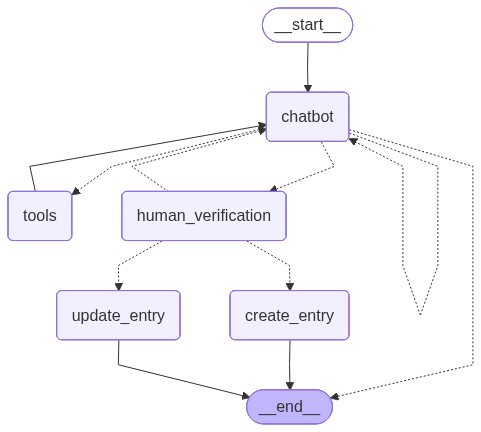

In [23]:
# Visualize the workflow
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

# Run the workflow

In [ ]:
# =============================================================================
# RUN THE WORKFLOW
# =============================================================================
# Initialize state with all contract fields and run the conversation.
# Allows starting fresh or continuing a previous conversation.

import uuid

# Track the last session for potential continuation
# (This variable persists between cell runs in the same kernel session)
if 'last_thread_id' not in dir():
    last_thread_id = None

# Initial state with all fields set to defaults
def get_initial_state():
    return {
        # Conversation
        "messages": [],
        # Metadata
        "contract_version": "",
        "info_complete": False,
        "human_decision": "",
        # Common fields
        "full_name": "",
        "gender": "",
        "job_title": "",
        "start_date": "",
        "contract_signing_date": "",
        "company_signatory": "",
        # Version-specific fields
        "end_date": None,
        "workload_percentage": None,
        "annual_gross_salary": None,
        "monthly_gross_salary": None,
        "hourly_salary": None,
        "hourly_workload_per_month": None,
        "original_contract_starting_date": None,
        "original_contract_signing_date": None,
        # Calculated
        "weekly_working_hours": None,
        # Final output
        "contract_json": None,
    }


def check_conversation_status(thread_id: str) -> dict:
    """Check the status of a previous conversation."""
    config = {"configurable": {"thread_id": thread_id}}
    state = app.get_state(config)
    if state and state.values:
        return {
            "exists": True,
            "completed": state.values.get("human_decision") in ["approve", "cancel"],
            "info_complete": state.values.get("info_complete", False),
            "full_name": state.values.get("full_name", ""),
            "contract_json": state.values.get("contract_json"),  # Get final JSON if available
        }
    return {"exists": False, "completed": False}


def run_workflow(thread_id: str, initial_state=None):
    """Run the workflow with given thread_id."""
    config = {
        "configurable": {"thread_id": thread_id},
        "recursion_limit": 100,  # Allow longer conversations
    }
    for event in app.stream(initial_state, config):
        pass
    
    # Return final state for access to contract_json
    return app.get_state(config)


# --- MAIN LOGIC ---
print("=" * 50)
print("CONTRACT DATA COLLECTION")
print("=" * 50)

final_state = None

if last_thread_id:
    # Check status of previous conversation
    status = check_conversation_status(last_thread_id)
    
    if status["exists"] and not status["completed"]:
        # Previous conversation exists and is not complete
        print(f"\n1. Start NEW conversation")
        print(f"2. CONTINUE previous conversation ({last_thread_id})")
        if status["full_name"]:
            print(f"   (Employee: {status['full_name']})")
        choice = input("\nEnter 1 or 2: ").strip()
        
        if choice == "2":
            thread_id = last_thread_id
            print(f"\n🔄 Resuming conversation: {thread_id}\n")
            final_state = run_workflow(thread_id, None)
        else:
            thread_id = f"contract-{uuid.uuid4().hex[:8]}"
            last_thread_id = thread_id
            print(f"\n🚀 Starting NEW conversation: {thread_id}\n")
            final_state = run_workflow(thread_id, get_initial_state())
    else:
        # Previous conversation completed or doesn't exist
        if status["completed"]:
            print(f"\n(Previous conversation was completed)")
        thread_id = f"contract-{uuid.uuid4().hex[:8]}"
        last_thread_id = thread_id
        print(f"\n🚀 Starting NEW conversation: {thread_id}\n")
        final_state = run_workflow(thread_id, get_initial_state())
else:
    # No previous conversation
    thread_id = f"contract-{uuid.uuid4().hex[:8]}"
    last_thread_id = thread_id
    print(f"\n🚀 Starting conversation: {thread_id}\n")
    final_state = run_workflow(thread_id, get_initial_state())

print("\n🏁 Workflow complete!")

# Store the contract JSON for programmatic access
if final_state and final_state.values:
    contract_result = final_state.values.get("contract_json")
    if contract_result:
        print("\n💾 Contract JSON stored in variable: contract_result")

# Future Improvements

## Must Do (after / during integration)
- Connect to database for actual contract storage
- Create a web interface for the chatbot 
- Add document generation (output actual contract words)
- replace all the prints with something more interactive

## Can do (Potential enhancements)
- Add real-time currency conversion tool (fetch current exchange rates)         
✅ Add LangSmith integration for monitoring LLM usage and costs

# Corrected problems

- It would not get the correct date.
- Tip any date that the user would give despite the lack of logic.